# Data preprocessing

- Written by Yeon Soo Choi, Technical Officer, Research Unit, World Customs Organization
- Updated on 2020.6.30

## Summary

Preprocessing import data includes the following steps;
- Generating new meaningful/indicative variables from combining existing variables 
    - Example 1) Unit price of products (= CIF value / Quantity) could be a risk indicator of under/over-valuation within homogeneous product groups.
    - Example 2) Combination of HScodes and origin countries could be a risk indicator of supply chains.
    - Example 3) Combination of importer-ids and Customs-offices (or officials) could be a risk indicator of bad practices/collusions. 
- **Risk profiling of categorical variables**
    - Risk profiling in Customs enforcement is, for a given trade entity, to calculate its historical records of non-compliance (eg. a number of historical frauds, a ratio of frauds to its total imports or whether it belongs to a blacklist).
    - From a perspective of risk management, such non-compliance records could be a good risk indicator of its future frauds.  
    - From a technical perspective of machine learning, risk profiling is a good tactic to include categorical variables in a model. As machine learning models accept only numbers, any categorical variables we want to keep in our model need to be transformed to numbers. 

Preprocessed data is also useful in making rules for your current rule-based targeting systems. 

## Outline

1. Set environment and load data
2. Preprocess data  
    2.1. Step-by-Step  
    2.2. One-shot approach with functions
3. Visualization

## 1. Set environment and load data

In [1]:
# Set environment
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
pd.set_option('display.max_columns', 100)

In [2]:
# Load data
df_raw = pd.read_csv('./synthetic_data2.csv')

In [3]:
# Preview of 5 sample lines of data
df_raw.sample(5)

,Unnamed: 0,year,month,day,OFFICE,IMPORTER.TIN,TARIFF.CODE,ORIGIN.CODE,CIF_USD_EQUIVALENT,QUANTITY,GROSS.WEIGHT,TOTAL.TAXES.USD,RAISED_TAX_AMOUNT_USD,illicit
198943,198943,2014,12,26,OFFICE187,IMPO11200,9606100010,CNTRY994,23576.0,300.0,342.0,5.0,-0.0,0
45035,45035,2013,5,10,OFFICE168,IMPO17356,8708999799,CNTRY976,20654.0,493.0,1.0,5.0,-0.0,0
159365,159365,2014,6,30,OFFICE162,IMPO19640,6211390099,CNTRY485,526.0,103.0,1.0,3927.0,193.0,1
164310,164310,2014,7,25,OFFICE51,IMP934643,8703232225,CNTRY376,68205.0,6552.0,25894.0,6711.0,-0.0,0
110301,110301,2013,12,22,OFFICE296,IMPO14046,8448490090,CNTRY123,10282.0,1.0,1.0,487.0,315.0,1


In [4]:
# Check columns (features, attributes)
df_raw.columns

Index(['Unnamed: 0', 'year', 'month', 'day', 'OFFICE', 'IMPORTER.TIN',
       'TARIFF.CODE', 'ORIGIN.CODE', 'CIF_USD_EQUIVALENT', 'QUANTITY',
       'GROSS.WEIGHT', 'TOTAL.TAXES.USD', 'RAISED_TAX_AMOUNT_USD', 'illicit'],
      dtype='object')

In [5]:
# Select columns to use
columns_to_use = ['year', 'month', 'day', 'OFFICE', 'IMPORTER.TIN',
       'TARIFF.CODE', 'ORIGIN.CODE', 'CIF_USD_EQUIVALENT', 'QUANTITY',
       'GROSS.WEIGHT','TOTAL.TAXES.USD', 'illicit']
df_raw = df_raw[columns_to_use]

In [6]:
# Define categorical variables
categorical_variables = ['year', 'month', 'day', 'OFFICE', 'IMPORTER.TIN',
       'TARIFF.CODE', 'ORIGIN.CODE']
# Transform/confirm data type of categorical variables as string
df_raw.loc[:,categorical_variables] = df_raw.loc[:,categorical_variables].astype(str)

# 2. Preprocess data

In [7]:
# Make a copy not to change the origincal data (to be used later)
df = df_raw.copy()

## 2.1. Step-by-Step
### 2.1.1. Create additional numeric variables

In [8]:
# create additional numeric variables
df.loc[:, 'Unitprice'] = df['CIF_USD_EQUIVALENT']/df['QUANTITY']
df.loc[:, 'WUnitprice'] = df['CIF_USD_EQUIVALENT']/df['GROSS.WEIGHT']
df.loc[:, 'TaxRatio'] = df['TOTAL.TAXES.USD'] / df['CIF_USD_EQUIVALENT']
df.loc[:, 'TaxUnitquantity'] = df['TOTAL.TAXES.USD'] / df['QUANTITY']

In [9]:
df.sample(5)

,year,month,day,OFFICE,IMPORTER.TIN,TARIFF.CODE,ORIGIN.CODE,CIF_USD_EQUIVALENT,QUANTITY,GROSS.WEIGHT,TOTAL.TAXES.USD,illicit,Unitprice,WUnitprice,TaxRatio,TaxUnitquantity
46594,2013,5,16,OFFICE187,IMPO10873,2931909001,CNTRY407,4207.0,18.0,319.0,1511.0,0,233.722222,13.188088,0.359163,83.944444
152974,2014,5,30,OFFICE243,IMPO14490,9801000000,CNTRY819,1121.0,11.0,906.0,319.0,1,101.909091,1.237307,0.284567,29.000000
40630,2013,4,28,OFFICE60,IMP901579,8423820000,CNTRY680,31083.0,1410.0,23961.0,3015.0,0,22.044681,1.297233,0.096998,2.138298
129845,2014,3,7,OFFICE197,IMPO13467,8431100002,CNTRY316,1477.0,3.0,237.0,440.0,0,492.333333,6.232068,0.297901,146.666667
6839,2013,1,22,OFFICE60,IMP392040,8703900000,CNTRY284,41032.0,1.0,24264.0,2269.0,0,41032.000000,1.691065,0.055298,2269.000000


### 2.1.2. Create additional categorical variables: Merge features/attributes

### Generate HS6 code 

In [10]:
df.loc[:, 'HS6'] = df['TARIFF.CODE'].apply(lambda x: int(x) // 10000).astype(str) #HS10digit
df.loc[:, 'HS4'] = df['HS6'].apply(lambda x: int(x) // 100).astype(str)
df.loc[:, 'HS2'] = df['HS4'].apply(lambda x: int(x) // 100).astype(str)

### Example: Merging 'OFFICE' and 'IPORTER.TIN'
This new feature is useful to check whether there is any collusion btw importers and Customs offices.

In [11]:
# Set the new column name
ColName = 'OFFICE'+'&'+'IMPORTER.TIN'
ColName

'OFFICE&IMPORTER.TIN'

In [12]:
# Merge the two columns
df.loc[:,ColName] = df.loc[:,'OFFICE']+'&'+df.loc[:,'IMPORTER.TIN']
df.loc[:5, ColName]

0    OFFICE60&IMP545640
1    OFFICE24&IMP252323
2    OFFICE59&IMP194834
3    OFFICE60&IMP668188
4    OFFICE59&IMP395619
5    OFFICE40&IMP450852
Name: OFFICE&IMPORTER.TIN, dtype: object

### Example: Merging all the pairs among the selected categorical variables

In [13]:
# set environment
import itertools

# Create all the pairs (combinations)
combinations = list(itertools.combinations(['OFFICE', 'IMPORTER.TIN','HS6', 'ORIGIN.CODE'], 2))
combinations

[('OFFICE', 'IMPORTER.TIN'),
 ('OFFICE', 'HS6'),
 ('OFFICE', 'ORIGIN.CODE'),
 ('IMPORTER.TIN', 'HS6'),
 ('IMPORTER.TIN', 'ORIGIN.CODE'),
 ('HS6', 'ORIGIN.CODE')]

In [14]:
# Run a loop for merging attributes 
for (cat1, cat2) in combinations:
    ColName = cat1 + '&' + cat2
    df.loc[:,ColName] = df.loc[:,cat1]+'&'+df.loc[:,cat2]

df.head()

,year,month,day,OFFICE,IMPORTER.TIN,TARIFF.CODE,ORIGIN.CODE,CIF_USD_EQUIVALENT,QUANTITY,GROSS.WEIGHT,TOTAL.TAXES.USD,illicit,Unitprice,WUnitprice,TaxRatio,TaxUnitquantity,HS6,HS4,HS2,OFFICE&IMPORTER.TIN,OFFICE&HS6,OFFICE&ORIGIN.CODE,IMPORTER.TIN&HS6,IMPORTER.TIN&ORIGIN.CODE,HS6&ORIGIN.CODE
0,2013,1,1,OFFICE60,IMP545640,8703232225,CNTRY680,172710.0,1.0,28487.0,3492.0,0,172710.000000,6.062765,0.020219,3492.000000,870323,8703,87,OFFICE60&IMP545640,OFFICE60&870323,OFFICE60&CNTRY680,IMP545640&870323,IMP545640&CNTRY680,870323&CNTRY680
1,2013,1,1,OFFICE24,IMP252323,8703321220,CNTRY376,7450.0,1.0,185994.0,503.0,0,7450.000000,0.040055,0.067517,503.000000,870332,8703,87,OFFICE24&IMP252323,OFFICE24&870332,OFFICE24&CNTRY376,IMP252323&870332,IMP252323&CNTRY376,870332&CNTRY376
2,2013,1,1,OFFICE59,IMP194834,8704212025,CNTRY680,2684.0,1.0,452843.0,5706.0,0,2684.000000,0.005927,2.125931,5706.000000,870421,8704,87,OFFICE59&IMP194834,OFFICE59&870421,OFFICE59&CNTRY680,IMP194834&870421,IMP194834&CNTRY680,870421&CNTRY680
3,2013,1,1,OFFICE60,IMP668188,3901100000,CNTRY277,7412.0,2018.0,26546.0,3182.0,0,3.672944,0.279213,0.429304,1.576809,390110,3901,39,OFFICE60&IMP668188,OFFICE60&390110,OFFICE60&CNTRY277,IMP668188&390110,IMP668188&CNTRY277,390110&CNTRY277
4,2013,1,1,OFFICE59,IMP395619,8517180000,CNTRY759,2786.0,7044.0,1958.0,587.0,0,0.395514,1.422880,0.210696,0.083333,851718,8517,85,OFFICE59&IMP395619,OFFICE59&851718,OFFICE59&CNTRY759,IMP395619&851718,IMP395619&CNTRY759,851718&CNTRY759


### 2.1.3. Risk profiling
Histories in legal compliance of importers is a good risk indicator. 
In addition, as machines accept only numbers not classes/categories, risk profiling is a good way of transforming categorical variables to numeric variables. 

### Identify high-risk importer list (High-risk list)

In [15]:
# 1) Group data by importers, 2) count the number of frauds for each importer, 3) sort the top 5 fraudulent importers

df.groupby('IMPORTER.TIN')['illicit'].sum().sort_values(ascending=False)[:5]

IMPORTER.TIN
IMP826164    19
IMP450852    17
IMP238427    16
IMP445164    15
IMP894296    15
Name: illicit, dtype: int64

In [16]:
# 1) Group data by importers, 2) Calculate number of imports, number of frauds, and ratio of frauds for each importer

def fraud_ratio(x):
    return x.sum()/x.count()
importer_risk_profiles = df.groupby('IMPORTER.TIN')['illicit'].agg(['count', 'sum', fraud_ratio])
importer_risk_profiles.columns = ['N_imports', 'N_frauds', 'Ratio_frauds']

# Present 5 samples of risk profiling
importer_risk_profiles.sample(5)

,N_imports,N_frauds,Ratio_frauds
IMPORTER.TIN,,,
IMP482328,3,1,0.333333
IMPO17787,7,2,0.285714
IMPO19351,8,5,0.625000
IMPO13141,3,0,0.000000
IMPO13852,62,2,0.032258


### Tag 'RiskH' to the imports of the top 10% high risky importers

In [17]:
# Find the top 10% of risky importers, and tag them as "Risk.H" (identify a blacklist)
N_importers = df['IMPORTER.TIN'].nunique()
N_top10pct = int(0.1*N_importers)+1
RiskH = list(importer_risk_profiles['N_frauds'].sort_values(ascending=False).head(N_top10pct).index)

# Tagging 1 for the importers are in the blacklist
df['RiskH.IMPORTER.TIN'] = np.where(df['IMPORTER.TIN'].isin(RiskH),1,0)

# Print 5 samples of tags
df[['IMPORTER.TIN', 'RiskH.IMPORTER.TIN']].sample(5)

,IMPORTER.TIN,RiskH.IMPORTER.TIN
101151,IMPO18208,1
63441,IMP965305,1
54470,IMPO10344,1
62762,IMPO15321,1
145514,IMPO10524,0


## 2.2. One shot approach with functions
So far, we explored how to transform data with some examples. 
Now, we will construct functions which can implement the above process automatically.

In [18]:
# Reload data
df = df_raw.copy()

In [19]:
# Create additional numeric and categorical variables

def preprocess(df:pd.DataFrame, 
               args:list):
    """
    dtype df: dataframe
    dtype *args: strings (attribute names that want to be combined)
    """
    # create additional numeric variables
    df.loc[:, 'Unitprice'] = df.loc[:,'CIF_USD_EQUIVALENT']/df.loc[:,'QUANTITY']
    df.loc[:, 'WUnitprice'] = df.loc[:,'CIF_USD_EQUIVALENT']/df.loc[:,'GROSS.WEIGHT']
    df.loc[:, 'TaxRatio'] = df.loc[:,'TOTAL.TAXES.USD'] / df.loc[:,'CIF_USD_EQUIVALENT']
    df.loc[:, 'TaxUnitquantity'] = df.loc[:,'TOTAL.TAXES.USD'] / df.loc[:,'QUANTITY']
    
    # Create HS sub-classes
    df.loc[:, 'HS6'] = df['TARIFF.CODE'].apply(lambda x: int(x) // 10000).astype(str) #HS10digit
    df.loc[:, 'HS4'] = df['HS6'].apply(lambda x: int(x) // 100).astype(str)
    df.loc[:, 'HS2'] = df['HS4'].apply(lambda x: int(x) // 100).astype(str)
    
    # Merge attributes
    
    df.loc[:,args] = df.loc[:,args].astype(str)
    
    # Generate all the pairs available from the selected categorical variables
    import itertools
    combinations = list(itertools.combinations(args, 2))
    
    # Run a loop for merging attributes 
    for (cat1, cat2) in combinations:
        ColName = cat1 + '&' + cat2
        df.loc[:,ColName] = df.loc[:,cat1]+'&'+df.loc[:,cat2]
    
    return df

In [20]:
# Identify high risky entities (importer, declarants, HScodes, Offices, origin countries, etc.)

def risk_profiling(df:pd.DataFrame, 
                   feature:str, 
                   topk_ratio:float):
    
    N_top10pct = int(df[feature].nunique()*topk_ratio)+1
    RiskH_list = list(df.groupby(feature)['illicit'].sum().sort_values(ascending=True).head(N_top10pct).index)
    
    return RiskH_list

In [21]:
def risk_tagging(df:pd.DataFrame, 
                 feature:str, 
                 RiskH_list:list):
    
    df.loc[:,'RiskH.'+feature] = np.where(df.loc[:,feature].isin(RiskH_list),1,0)
    
    return df

In [22]:
# split train/valid/test set

train = df[df['year']=='2013']
test = df[df['year']=='2014']
print("Now, train-data has {} entries and {} features".format(*train.shape))
print("Now, test-data has {} entries and {} features".format(*test.shape))

Now, train-data has 113223 entries and 12 features
Now, test-data has 86777 entries and 12 features


In [23]:
# Preprocess train and test
train = preprocess(train, ['OFFICE', 'IMPORTER.TIN','TARIFF.CODE', 'ORIGIN.CODE'])
test = preprocess(test, ['OFFICE', 'IMPORTER.TIN','TARIFF.CODE', 'ORIGIN.CODE'])

/newsdd/bacuda_big/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/newsdd/bacuda_big/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [24]:
profile_candidates = ['OFFICE', 'IMPORTER.TIN','TARIFF.CODE', 'HS6', 'HS4', 'HS2', 'ORIGIN.CODE']\
+[col for col in train.columns if '&' in col]

In [25]:
# Risk profiling
for feature in profile_candidates:
    # Identify high risky entities 
    RiskH_list = risk_profiling(train, feature, 0.1)
    # Tag 'RiskH'
    train = risk_tagging(train, feature, RiskH_list)
    # Attention: Tags for test data are built from train data (not from test data)
    test = risk_tagging(test, feature, RiskH_list)

In [26]:
train.sample(5)

,year,month,day,OFFICE,IMPORTER.TIN,TARIFF.CODE,ORIGIN.CODE,CIF_USD_EQUIVALENT,QUANTITY,GROSS.WEIGHT,TOTAL.TAXES.USD,illicit,Unitprice,WUnitprice,TaxRatio,TaxUnitquantity,HS6,HS4,HS2,OFFICE&IMPORTER.TIN,OFFICE&TARIFF.CODE,OFFICE&ORIGIN.CODE,IMPORTER.TIN&TARIFF.CODE,IMPORTER.TIN&ORIGIN.CODE,TARIFF.CODE&ORIGIN.CODE,RiskH.OFFICE,RiskH.IMPORTER.TIN,RiskH.TARIFF.CODE,RiskH.HS6,RiskH.HS4,RiskH.HS2,RiskH.ORIGIN.CODE,RiskH.OFFICE&IMPORTER.TIN,RiskH.OFFICE&TARIFF.CODE,RiskH.OFFICE&ORIGIN.CODE,RiskH.IMPORTER.TIN&TARIFF.CODE,RiskH.IMPORTER.TIN&ORIGIN.CODE,RiskH.TARIFF.CODE&ORIGIN.CODE
80439,2013,9,23,OFFICE100,IMPO12270,7322190009,CNTRY456,110.0,3931.0,1.0,5.0,0,0.027983,110.000000,0.045455,0.001272,732219,7322,73,OFFICE100&IMPO12270,OFFICE100&7322190009,OFFICE100&CNTRY456,IMPO12270&7322190009,IMPO12270&CNTRY456,7322190009&CNTRY456,0,1,0,0,0,0,0,0,0,0,1,1,0
107306,2013,12,13,OFFICE51,IMP898068,3808920000,CNTRY680,2836.0,1.0,28620.0,507.0,0,2836.000000,0.099092,0.178773,507.000000,380892,3808,38,OFFICE51&IMP898068,OFFICE51&3808920000,OFFICE51&CNTRY680,IMP898068&3808920000,IMP898068&CNTRY680,3808920000&CNTRY680,0,0,0,0,0,0,0,0,0,0,0,0,0
25295,2013,3,20,OFFICE51,IMP122694,8702101319,CNTRY759,150474.0,1.0,456840.0,28678.0,0,150474.000000,0.329380,0.190584,28678.000000,870210,8702,87,OFFICE51&IMP122694,OFFICE51&8702101319,OFFICE51&CNTRY759,IMP122694&8702101319,IMP122694&CNTRY759,8702101319&CNTRY759,0,0,0,0,0,0,0,1,0,0,0,0,0
67191,2013,8,8,OFFICE94,IMP385159,303790000,CNTRY138,5611.0,839.0,1998.0,-0.0,0,6.687723,2.808308,-0.000000,-0.000000,30379,303,3,OFFICE94&IMP385159,OFFICE94&303790000,OFFICE94&CNTRY138,IMP385159&303790000,IMP385159&CNTRY138,303790000&CNTRY138,0,0,0,0,0,0,0,0,0,0,0,0,0
28879,2013,4,3,OFFICE23,IMP179534,8703222900,CNTRY759,115194.0,1.0,25478.0,164175.0,0,115194.000000,4.521313,1.425204,164175.000000,870322,8703,87,OFFICE23&IMP179534,OFFICE23&8703222900,OFFICE23&CNTRY759,IMP179534&8703222900,IMP179534&CNTRY759,8703222900&CNTRY759,0,0,0,0,0,0,0,0,0,0,0,0,0


In [27]:
test.sample(5)

,year,month,day,OFFICE,IMPORTER.TIN,TARIFF.CODE,ORIGIN.CODE,CIF_USD_EQUIVALENT,QUANTITY,GROSS.WEIGHT,TOTAL.TAXES.USD,illicit,Unitprice,WUnitprice,TaxRatio,TaxUnitquantity,HS6,HS4,HS2,OFFICE&IMPORTER.TIN,OFFICE&TARIFF.CODE,OFFICE&ORIGIN.CODE,IMPORTER.TIN&TARIFF.CODE,IMPORTER.TIN&ORIGIN.CODE,TARIFF.CODE&ORIGIN.CODE,RiskH.OFFICE,RiskH.IMPORTER.TIN,RiskH.TARIFF.CODE,RiskH.HS6,RiskH.HS4,RiskH.HS2,RiskH.ORIGIN.CODE,RiskH.OFFICE&IMPORTER.TIN,RiskH.OFFICE&TARIFF.CODE,RiskH.OFFICE&ORIGIN.CODE,RiskH.IMPORTER.TIN&TARIFF.CODE,RiskH.IMPORTER.TIN&ORIGIN.CODE,RiskH.TARIFF.CODE&ORIGIN.CODE
134603,2014,4,1,OFFICE296,IMPO12343,8716398090,CNTRY994,3459.0,16.0,39.0,5.0,0,216.187500,88.692308,0.001446,0.312500,871639,8716,87,OFFICE296&IMPO12343,OFFICE296&8716398090,OFFICE296&CNTRY994,IMPO12343&8716398090,IMPO12343&CNTRY994,8716398090&CNTRY994,0,0,0,0,0,0,0,0,1,0,1,1,0
163690,2014,7,21,OFFICE127,IMPO18898,5806400003,CNTRY139,271.0,657.0,295.0,1785.0,0,0.412481,0.918644,6.586716,2.716895,580640,5806,58,OFFICE127&IMPO18898,OFFICE127&5806400003,OFFICE127&CNTRY139,IMPO18898&5806400003,IMPO18898&CNTRY139,5806400003&CNTRY139,0,0,0,0,0,0,0,0,0,0,0,0,0
179161,2014,10,8,OFFICE92,IMP182336,8432100000,CNTRY389,36716.0,748.0,26.0,383.0,0,49.085561,1412.153846,0.010431,0.512032,843210,8432,84,OFFICE92&IMP182336,OFFICE92&8432100000,OFFICE92&CNTRY389,IMP182336&8432100000,IMP182336&CNTRY389,8432100000&CNTRY389,0,0,0,0,0,0,0,0,0,0,0,0,0
127207,2014,2,25,OFFICE134,IMPO15253,8536908591,CNTRY680,5752.0,1.0,19.0,5.0,0,5752.000000,302.736842,0.000869,5.000000,853690,8536,85,OFFICE134&IMPO15253,OFFICE134&8536908591,OFFICE134&CNTRY680,IMPO15253&8536908591,IMPO15253&CNTRY680,8536908591&CNTRY680,0,0,0,0,0,0,0,0,0,0,0,0,0
119624,2014,1,27,OFFICE24,IMP756329,8474900000,CNTRY713,1855.0,210.0,718.0,497.0,0,8.833333,2.583565,0.267925,2.366667,847490,8474,84,OFFICE24&IMP756329,OFFICE24&8474900000,OFFICE24&CNTRY713,IMP756329&8474900000,IMP756329&CNTRY713,8474900000&CNTRY713,0,1,0,0,0,0,0,0,0,0,0,0,0


# 3. Visualization

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as ex

In [29]:
train.columns

Index(['year', 'month', 'day', 'OFFICE', 'IMPORTER.TIN', 'TARIFF.CODE',
       'ORIGIN.CODE', 'CIF_USD_EQUIVALENT', 'QUANTITY', 'GROSS.WEIGHT',
       'TOTAL.TAXES.USD', 'illicit', 'Unitprice', 'WUnitprice', 'TaxRatio',
       'TaxUnitquantity', 'HS6', 'HS4', 'HS2', 'OFFICE&IMPORTER.TIN',
       'OFFICE&TARIFF.CODE', 'OFFICE&ORIGIN.CODE', 'IMPORTER.TIN&TARIFF.CODE',
       'IMPORTER.TIN&ORIGIN.CODE', 'TARIFF.CODE&ORIGIN.CODE', 'RiskH.OFFICE',
       'RiskH.IMPORTER.TIN', 'RiskH.TARIFF.CODE', 'RiskH.HS6', 'RiskH.HS4',
       'RiskH.HS2', 'RiskH.ORIGIN.CODE', 'RiskH.OFFICE&IMPORTER.TIN',
       'RiskH.OFFICE&TARIFF.CODE', 'RiskH.OFFICE&ORIGIN.CODE',
       'RiskH.IMPORTER.TIN&TARIFF.CODE', 'RiskH.IMPORTER.TIN&ORIGIN.CODE',
       'RiskH.TARIFF.CODE&ORIGIN.CODE'],
      dtype='object')

## Identify top fraudulent importers

In [30]:
data = train.groupby('IMPORTER.TIN')['illicit'].sum().reset_index()
data = data.sort_values('illicit', ascending = False)
data.rename(columns={'illicit':'N_frauds'},
            inplace=True)
data.head(5)

,IMPORTER.TIN,N_frauds
5801,IMP826164,13
2835,IMP450852,13
6360,IMP894296,12
4274,IMP638175,11
6405,IMP900492,10


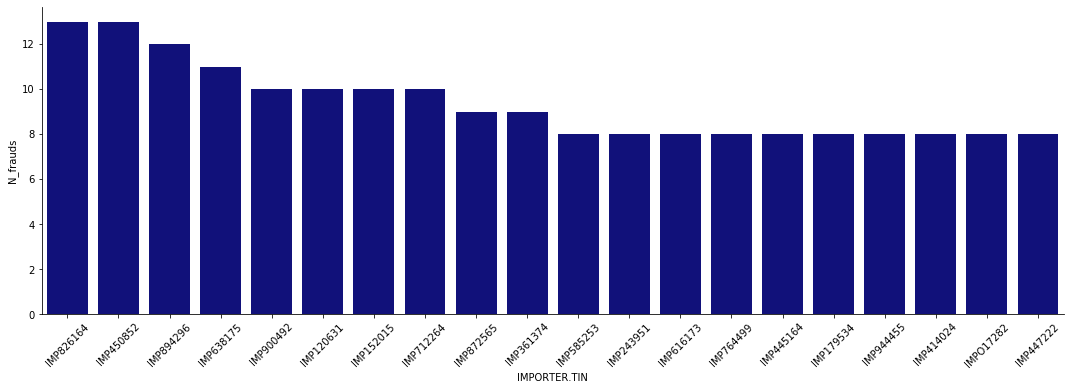

In [31]:
fig = sns.catplot(x='IMPORTER.TIN',
                  y='N_frauds',
                  data = data.iloc[:20,:],
                  color='darkblue',
                  kind='bar',
                  height=5, # make the plot 5 units high
                  aspect=3) # width should be three times height)
fig.set_xticklabels(rotation=45)

In [32]:
# Interactive visualization
#fig = px.bar(data.iloc[:20,:], x="IMPORTER.TIN", y="N_frauds", )
#fig.show()

## Identify top fraudulent pairs of offices and importers

In [33]:
data = train.groupby('OFFICE&IMPORTER.TIN')['illicit'].sum().reset_index()
data = data.sort_values('illicit', ascending = False)
data.rename(columns={'illicit':'N_frauds'},
            inplace=True)
data.head(5)

,OFFICE&IMPORTER.TIN,N_frauds
27194,OFFICE51&IMP826164,7
25978,OFFICE51&IMP450852,5
26576,OFFICE51&IMP638175,5
25854,OFFICE51&IMP414024,5
24997,OFFICE51&IMP152015,5


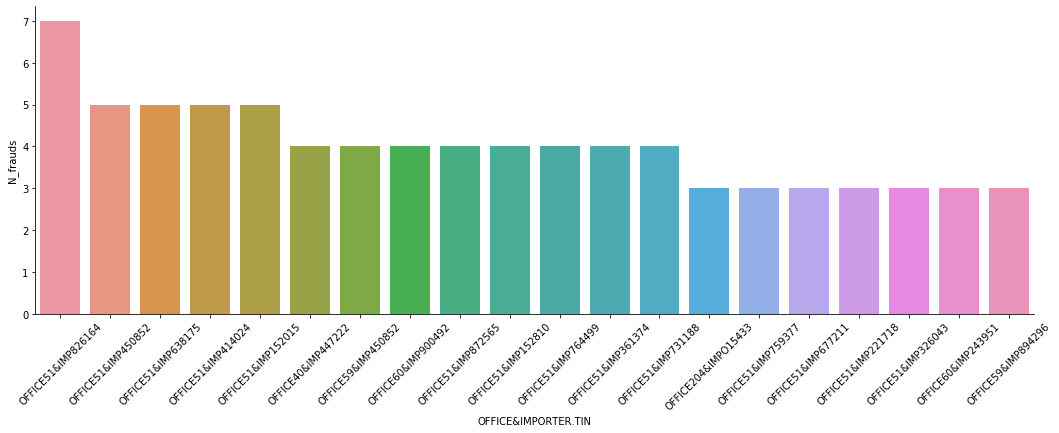

In [34]:
fig = sns.catplot(x='OFFICE&IMPORTER.TIN',
                  y='N_frauds',
                  data = data.iloc[:20,:],
                  kind='bar',
                  height=5, # make the plot 5 units high
                  aspect=3) # width should be three times height)
fig.set_xticklabels(rotation=45)

In [35]:
# Interactive visualization
#fig = px.bar(data.iloc[:20,:], x="OFFICE&IMPORTER.TIN", y="N_frauds")
#fig.show()